In [32]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx
from cartopy.geodesic import Geodesic
from shapely.geometry.polygon import Point, Polygon
from shapely.geometry import shape
from shapely.ops import unary_union
from shapely.geometry.multipolygon import MultiPolygon
import nhstravel.loaders.lsoaloader as lsoaloader
import folium
import geopandas as gpd

In [9]:
#load in the post code to lsoa look up sheet
postcode_lookup = pd.read_csv('data/PCD_OA21_LSOA21_MSOA21_LAD_NOV22_UK_LU 3.csv', encoding = "ISO-8859-1")
postcode_lookup.head()

/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/1090205016.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  postcode_lookup = pd.read_csv('data/PCD_OA21_LSOA21_MSOA21_LAD_NOV22_UK_LU 3.csv', encoding = "ISO-8859-1")


,pcd7,pcd8,pcds,dointr,doterm,usertype,oa21cd,lsoa21cd,msoa21cd,ladcd,lsoa21nm,msoa21nm,ladnm,ladnmw
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,S00090303,S01006514,S02001237,S12000033,NaN,NaN,Aberdeen City,NaN
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,S00090303,S01006514,S02001237,S12000033,NaN,NaN,Aberdeen City,NaN
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,0,S00090399,S01006514,S02001237,S12000033,NaN,NaN,Aberdeen City,NaN
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,0,S00091322,S01006853,S02001296,S12000034,NaN,NaN,Aberdeenshire,NaN
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,1,S00090299,S01006511,S02001236,S12000033,NaN,NaN,Aberdeen City,NaN


In [4]:
#load in the hospital data set to get the postcodes for lookup
#load in the hospital sites data to be used to score potential viable locations and filter for Cambridge
'''
hospitals = pd.read_csv('data/Hospital.csv')
surrey_hospitals = hospitals.loc[hospitals['County'] == 'Surrey']
surrey_hospitals
'''

"\nhospitals = pd.read_csv('data/Hospital.csv')\nsurrey_hospitals = hospitals.loc[hospitals['County'] == 'Surrey']\nsurrey_hospitals\n"

In [5]:
#define the target location post codes 
target_address1 = 'CB2 8AF' #4 Trumpington Road
target_address2 = 'CB2 0AY' #Nuffield Hospital (central cambridge location)
list_of_target_addresses = [target_address1, target_address2]



In [10]:
target_coords = []
for loc in list_of_target_addresses:
    target_coords.append(ox.geocode(loc))


target_coords

[(52.19006495, 0.12399715), (52.1735278, 0.1358808)]

In [11]:
#get the lsoa 2021 code from the lookup file
lsoa_codes = []
lsoa_names = []
for postcode in list_of_target_addresses:
    lsoa_codes.append(postcode_lookup.loc[postcode_lookup['pcds'] == postcode]['lsoa21cd'].values[0])
    lsoa_names.append(postcode_lookup.loc[postcode_lookup['pcds'] == postcode]['ladnm'].values[0])

lsoa_names

['Cambridge', 'Cambridge']

In [12]:
#load in lsoa data using the loaders function in nhs travel
lsoa_with_population_pd1 = lsoaloader.build_lsoa_data_frame_for_area_england(lsoa_names[0])
remapped_lsoa1 = lsoaloader.load_geo_json_shapefiles_for_lsoas(lsoa_with_population_pd1, lsoa_names[0])

In [13]:
target_coords1 = target_coords[0]

gd = Geodesic()
bounding_poly1 = Polygon(gd.circle(lon=target_coords1[1], lat=target_coords1[0], radius=500))

target_point1 = Point(target_coords1[1], target_coords1[0])

neighboring_polys1 = {'lsoa_codes':[], 'population':[], 'polygons':[]}
for lsoa in remapped_lsoa1['features']:
    lsoa_polygon = shape(lsoa['geometry'])
    if lsoa_polygon.contains(target_point1) or bounding_poly1.intersects(lsoa_polygon):
        neighboring_polys1['lsoa_codes'].append(lsoa['properties']['LSOA21CD'])
        neighboring_polys1['population'].append(lsoa['properties']['all ages'])
        neighboring_polys1['polygons'].append(lsoa_polygon)

In [14]:
#load in lsoa data using the loaders function in nhs travel
lsoa_with_population_pd2 = lsoaloader.build_lsoa_data_frame_for_area_england(lsoa_names[1])
remapped_lsoa2 = lsoaloader.load_geo_json_shapefiles_for_lsoas(lsoa_with_population_pd2, lsoa_names[1])

In [15]:
target_coords2 = target_coords[1]

gd = Geodesic()
bounding_poly2 = Polygon(gd.circle(lon=target_coords2[1], lat=target_coords2[0], radius=500))

target_point2 = Point(target_coords2[1], target_coords2[0])

neighboring_polys2 = {'lsoa_codes':[], 'population':[], 'polygons':[]}
for lsoa in remapped_lsoa2['features']:
    lsoa_polygon = shape(lsoa['geometry'])
    if lsoa_polygon.contains(target_point2) or bounding_poly2.intersects(lsoa_polygon):
        neighboring_polys2['lsoa_codes'].append(lsoa['properties']['LSOA21CD'])
        neighboring_polys2['population'].append(lsoa['properties']['all ages'])
        neighboring_polys2['polygons'].append(lsoa_polygon)

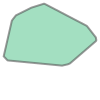

In [34]:
neighboring_polys_merged = neighboring_polys1['polygons']  + neighboring_polys2['polygons']
neighboring_multipoly = MultiPolygon(neighboring_polys_merged)
hull = neighboring_multipoly.convex_hull
hull

In [35]:
hull_neighboring_polys = {'lsoa_codes':[], 'population':[], 'polygons':[]}
for lsoa in remapped_lsoa1['features']:
    lsoa_polygon = shape(lsoa['geometry'])
    if hull.intersects(lsoa_polygon):
        hull_neighboring_polys['lsoa_codes'].append(lsoa['properties']['LSOA21CD'])
        hull_neighboring_polys['population'].append(lsoa['properties']['all ages'])
        hull_neighboring_polys['polygons'].append(lsoa_polygon)
hull_neighboring_polys

{'lsoa_codes': ['E01035516',
  'E01035517',
  'E01035518',
  'E01035519',
  'E01035520',
  'E01035521',
  'E01035522',
  'E01035523',
  'E01035524',
  'E01035525',
  'E01035526',
  'E01035527',
  'E01035528',
  'E01035529',
  'E01035530',
  'E01032794',
  'E01018225',
  'E01018254',
  'E01018256',
  'E01018291',
  'E01018292',
  'E01018293',
  'E01018294',
  'E01018295',
  'E01017959',
  'E01017960',
  'E01017961',
  'E01017965',
  'E01017968',
  'E01017969',
  'E01017985',
  'E01017987',
  'E01017988',
  'E01017992',
  'E01017994',
  'E01017995',
  'E01017996',
  'E01018001',
  'E01018005'],
 'population': [5735,
  3264,
  1680,
  2341,
  1962,
  1778,
  1979,
  1170,
  1521,
  1572,
  1995,
  1493,
  1523,
  1618,
  1411,
  1260,
  1040,
  1989,
  2560,
  1139,
  1542,
  1579,
  1741,
  1676,
  1787,
  1451,
  1213,
  1737,
  1571,
  1763,
  1887,
  1974,
  1759,
  2088,
  1900,
  2127,
  2073,
  1622,
  1819],
 'polygons': [<shapely.geometry.polygon.Polygon at 0x12c1cbc40>,
  <shape

In [36]:
neighboring_polys_merged = hull_neighboring_polys['polygons']
bounding_poly_merged = unary_union(neighboring_polys_merged)

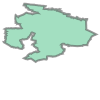

In [37]:
bounding_poly_merged

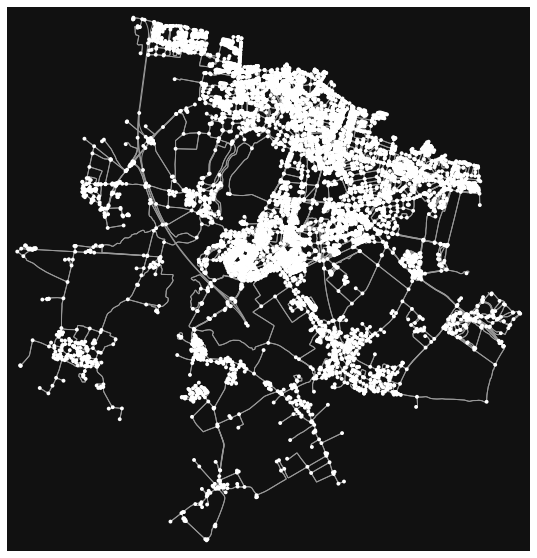

In [38]:
G = ox.graph_from_polygon(bounding_poly_merged)
#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));

In [39]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
104521,52.203550,0.123491,traffic_signals,3,NaN,POINT (0.12349 52.20355)
104522,52.204039,0.123043,NaN,3,NaN,POINT (0.12304 52.20404)
104524,52.205374,0.121364,NaN,3,NaN,POINT (0.12136 52.20537)
104549,52.203275,0.122379,NaN,3,NaN,POINT (0.12238 52.20328)
104550,52.202832,0.120612,NaN,3,NaN,POINT (0.12061 52.20283)
...,...,...,...,...,...,...
10700725510,52.176751,0.145584,crossing,3,NaN,POINT (0.14558 52.17675)
10700725512,52.176683,0.145695,crossing,3,NaN,POINT (0.14570 52.17668)
10700725516,52.176205,0.144357,crossing,3,NaN,POINT (0.14436 52.17620)


In [40]:
#convert the addresses to lat long coordinates and get the nearest node on the graph
target_coords1 = ox.geocode(target_address1)
target_node1 = ox.get_nearest_node(G, target_coords1)

target_coords2 = ox.geocode(target_address2)
target_node2 = ox.get_nearest_node(G, target_coords2)

list_of_target_nodes = [target_node1, target_node2]
list_of_target_coords = [target_coords1, target_coords2]

/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [42]:
#get the dataframe of nodes that are in the neighboring polys and get the sample nodes with the corresponding population and lsoa codes
nodes_sample1 = pd.DataFrame(columns = nodes.columns)
list_of_lsoa_codes = []
list_of_pops = []


for i in range(len(neighboring_polys1['polygons'])):
    lsoa = neighboring_polys1['polygons'][i]
    for j in range(nodes.shape[0]):
        if lsoa.contains(nodes.iloc[j]['geometry']):
            nodes_sample1 = nodes_sample1.append(nodes.iloc[j])
            list_of_lsoa_codes.append(neighboring_polys1['lsoa_codes'][i])
            list_of_pops.append(neighboring_polys1['population'][i])

nodes_sample1['lsoa_codes'] = list_of_lsoa_codes
nodes_sample1['lsoa_population'] = list_of_pops

nodes_sample1 = nodes_sample1.drop(target_node1)

nodes_sample1

/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/847404358.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample1 = nodes_sample1.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/847404358.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample1 = nodes_sample1.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/847404358.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample1 = nodes_sample1.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/847404358.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

,y,x,highway,street_count,ref,geometry,lsoa_codes,lsoa_population
21390894,52.191681,0.126768,NaN,3,NaN,POINT (0.126768 52.1916806),E01035523,1170
21390895,52.1918,0.127923,NaN,3,NaN,POINT (0.1279234 52.1918005),E01035523,1170
21390896,52.191848,0.128371,NaN,3,NaN,POINT (0.1283712 52.1918477),E01035523,1170
21390897,52.192046,0.130272,NaN,3,NaN,POINT (0.1302716 52.1920457),E01035523,1170
21390953,52.191943,0.127889,NaN,3,NaN,POINT (0.1278893 52.1919434),E01035523,1170
...,...,...,...,...,...,...,...,...
8593528636,52.196504,0.122065,NaN,1,NaN,POINT (0.1220646 52.1965044),E01018005,1819
8593528637,52.196505,0.122195,NaN,4,NaN,POINT (0.1221953 52.1965053),E01018005,1819
8593528638,52.196506,0.122297,NaN,3,NaN,POINT (0.1222969 52.1965062),E01018005,1819
8773605778,52.200221,0.12939,NaN,3,NaN,POINT (0.12939 52.2002209),E01018005,1819


In [43]:
#get the dataframe of nodes that are in the neighboring polys and get the sample nodes with the corresponding population and lsoa codes
nodes_sample2 = pd.DataFrame(columns = nodes.columns)
list_of_lsoa_codes = []
list_of_pops = []


for i in range(len(neighboring_polys2['polygons'])):
    lsoa = neighboring_polys2['polygons'][i]
    for j in range(nodes.shape[0]):
        if lsoa.contains(nodes.iloc[j]['geometry']):
            nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
            list_of_lsoa_codes.append(neighboring_polys2['lsoa_codes'][i])
            list_of_pops.append(neighboring_polys2['population'][i])

nodes_sample2['lsoa_codes'] = list_of_lsoa_codes
nodes_sample2['lsoa_population'] = list_of_pops

nodes_sample2 = nodes_sample2.drop(target_node2)

nodes_sample2

/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[j])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/195574021.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

,y,x,highway,street_count,ref,geometry,lsoa_codes,lsoa_population
554267,52.176732,0.144937,NaN,3,NaN,POINT (0.1449374 52.1767322),E01035521,1778
554269,52.176583,0.144625,NaN,3,NaN,POINT (0.1446246 52.1765832),E01035521,1778
554272,52.176316,0.145386,NaN,3,NaN,POINT (0.1453859 52.1763162),E01035521,1778
554274,52.176542,0.145601,NaN,3,NaN,POINT (0.1456013 52.1765419),E01035521,1778
554287,52.177293,0.144047,NaN,4,NaN,POINT (0.1440472 52.1772929),E01035521,1778
...,...,...,...,...,...,...,...,...
10700724202,52.176282,0.144509,crossing,4,NaN,POINT (0.1445088 52.1762819),E01017995,2127
10700724204,52.176245,0.14452,NaN,3,NaN,POINT (0.1445196 52.1762445),E01017995,2127
10700725505,52.176249,0.144609,crossing,3,NaN,POINT (0.1446091 52.176249),E01017995,2127
10700725516,52.176205,0.144357,crossing,3,NaN,POINT (0.1443574 52.1762049),E01017995,2127


In [65]:
nodes_sample = nodes_sample2
node = 554267
current_lsoa = nodes_sample['lsoa_codes'][node]
nodes_in_lsoa = nodes_sample.loc[nodes_sample['lsoa_codes']==current_lsoa].shape[0]
nodes_in_lsoa

219

In [25]:
#get the dataframe of nodes that are in the neighboring polys and get the sample nodes with the corresponding population and lsoa codes
nodes_sample1 = pd.DataFrame(columns = nodes.columns)
nodes_sample2 = pd.DataFrame(columns = nodes.columns)

list_of_lsoa_codes1 = []
list_of_pops1 = []

list_of_lsoa_codes2 = []
list_of_pops2 = []

for lsoa in neighboring_polys_merged:
    for i in range(nodes.shape[0]):
        if lsoa.contains(nodes.iloc[i]['geometry']):
            if lsoa in neighboring_polys1['polygons']:
                index = neighboring_polys1['polygons'].index(lsoa)
                list_of_lsoa_codes1.append(neighboring_polys1['lsoa_codes'][index])
                list_of_pops1.append(neighboring_polys1['population'][index])
                nodes_sample1 = nodes_sample1.append(nodes.iloc[i])
            elif lsoa in neighboring_polys2['polygons']:
                index = neighboring_polys2['polygons'].index(lsoa)
                list_of_lsoa_codes2.append(neighboring_polys2['lsoa_codes'][index])
                list_of_pops2.append(neighboring_polys2['population'][index])
                nodes_sample2 = nodes_sample2.append(nodes.iloc[i])
                
            

nodes_sample1['lsoa_codes'] = list_of_lsoa_codes1
nodes_sample1['lsoa_population'] = list_of_pops1

#nodes_sample1 = nodes_sample1.drop(target_node1)


nodes_sample2['lsoa_codes'] = list_of_lsoa_codes2
nodes_sample2['lsoa_population'] = list_of_pops2

nodes_sample2 = nodes_sample2.drop(target_node2)



nodes_sample1


/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/3283234485.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[i])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/3283234485.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[i])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/3283234485.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes_sample2 = nodes_sample2.append(nodes.iloc[i])
/var/folders/kt/92wnzvcj6qq_r6j3j19yp5lw0000gp/T/ipykernel_15875/3283234485.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

,y,x,street_count,highway,ref,geometry,lsoa_codes,lsoa_population


In [46]:
#creating a function to calculate a score from a list of lengths calculated from the target node to each of the 100 sample nodes
def create_score(list_of_lengths, list_of_multipliers):
    score = 1000
    for l, m in zip(list_of_lengths, list_of_multipliers):
        deduction = (((l/1000)/4.5)*60) * m * 5#get the length in km divide by speed 4.5 km/h then divide by 60 to get time in minutes
        score = score - deduction #decrement the score by the derivation of time taken to each of the 100 nodes
        return score

In [66]:
#define a function to calculate multiple shortest route lengths from the target node to each of the 100 sample nodes
def create_list_of_lengths(nodes_sample, target_node):
    list_of_lengths = []
    list_of_multipliers = []


    for node in nodes_sample.index:
        current_lsoa = nodes_sample['lsoa_codes'][node]
        nodes_in_lsoa = nodes_sample.loc[nodes_sample['lsoa_codes']==current_lsoa].shape[0]
        total_pop = nodes_sample['lsoa_population'].unique().sum()
        node_pop = nodes_sample['lsoa_population'][node]/nodes_in_lsoa
        multiplier = 1 - (node_pop/total_pop)
        try:
            length = nx.shortest_path_length(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        except Exception as e:
            pass
        list_of_lengths.append(length) #append the length to the list
        list_of_multipliers.append(multiplier) #append the multipliers to the list for score creation
    
    return [list_of_lengths, list_of_multipliers]
    

In [67]:
#run the function defined above to generate a list of lengths between the target nodes and sample nodes
#then generate the score for each and store them in a dictionary
target_scores = {}
target1_lengths = create_list_of_lengths(nodes_sample1, list_of_target_nodes[0])
target2_lengths = create_list_of_lengths(nodes_sample2, list_of_target_nodes[1])
target_scores['Site 1'] = create_score(target1_lengths[0], target1_lengths[1])
target_scores['Site 2'] = create_score(target2_lengths[0], target2_lengths[1])
target_scores

{'Site 1': 964.3471096179493, 'Site 2': 936.2236957469767}

In [68]:
#print the scores for each proposed target site
print('The score for Site 1: {} is {}'.format(target_address1, target_scores['Site 1']))
print('The score for Site 2: {} is {}'.format(target_address2, target_scores['Site 2']))

The score for Site 1: CB2 8AF is 964.3471096179493
The score for Site 2: CB2 0AY is 936.2236957469767


In [92]:
#initiate dictionary to store routes for all 100 nodes for each proposed site
target_to_nodes_routes = {}
target_node_names = ['Site1', 'Site2']

In [93]:
list_of_samples = [nodes_sample, nodes_sample]

In [94]:
#generate multiple shortest routes for each site and store in dictionary for plotting
for site, target_node in zip(target_node_names, list_of_target_nodes):
    list_of_routes = []
    for node in nodes_sample.index:
        try:
            route = nx.shortest_path(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        except Exception as el
        list_of_routes.append(route) #append the length to the list
    target_to_nodes_routes[site] = list_of_routes
    


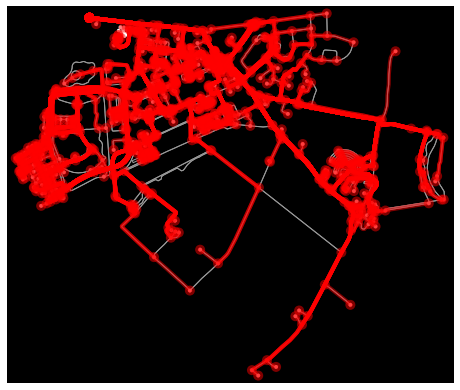

In [95]:
#plot the routes from Site 1 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site1'], route_linewidth=6, bgcolor='k')

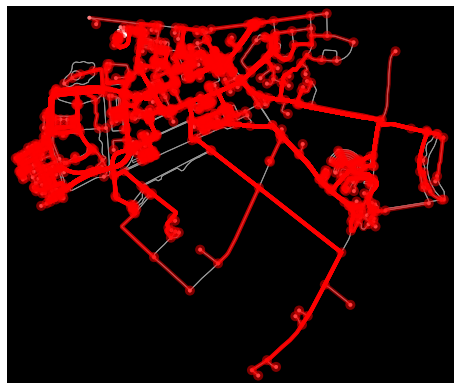

In [96]:
#plot the routes from Site 1 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site2'], route_linewidth=6, bgcolor='k')